Bibliotheken importieren

In [101]:
import os
from sklearn.utils import shuffle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import layers, models, applications
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
import cv2

TEMPORÄR: PIL/Pillow konfigurieren, um beschädigte Bilder ignorieren

In [102]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

Datensatz laden

In [103]:
# pfad definieren
base_dir = 'dataset'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'valid')
test_dir = os.path.join(base_dir, 'test')

def load_images(ordner, img_groesse=(32, 32)):
    bilder = []
    labels = []

    for klasse in os.listdir(ordner):
        klasse_pfad = os.path.join(ordner, klasse)
        if not os.path.isdir(klasse_pfad):
            continue

        print(f"Lade {klasse} Bilder aus {klasse_pfad}")
        for bild_datei in os.listdir(klasse_pfad):
            bild_pfad = os.path.join(klasse_pfad, bild_datei)
            bild = cv2.imread(bild_pfad)
            if bild is None:
                continue
            bild = cv2.resize(bild, img_groesse)
            bild = bild / 255.0
            bilder.append(bild)
            labels.append(1 if klasse == 'wildfire' else 0)

    return np.array(bilder), np.array(labels)

X_train, y_train = load_images(train_dir)
X_val, y_val = load_images(val_dir)
X_test, y_test = load_images(test_dir)

print(f"Training: {len(X_train)} Bilder")
print(f"Validierung: {len(X_val)} Bilder")
print(f"Test: {len(X_test)} Bilder")


Lade nowildfire Bilder aus dataset/train/nowildfire


Premature end of JPEG file


Lade wildfire Bilder aus dataset/train/wildfire
Lade nowildfire Bilder aus dataset/valid/nowildfire
Lade wildfire Bilder aus dataset/valid/wildfire
Lade nowildfire Bilder aus dataset/test/nowildfire
Lade wildfire Bilder aus dataset/test/wildfire


Premature end of JPEG file


Training: 30250 Bilder
Validierung: 6300 Bilder
Test: 6300 Bilder


In [104]:
# konvertiere labels zu kategorisch (one-hot encoding)
y_train_cat = to_categorical(y_train)
y_val_cat = to_categorical(y_val)
y_test_cat = to_categorical(y_test)

# mische daten
X_train, y_train_cat = shuffle(X_train, y_train_cat)

Datenvisualisierung

In [105]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

batch_size = 32
# erstelle trainingsdatensatz
train_generator = train_datagen.flow(
    X_train, y_train_cat,
    batch_size=batch_size
)

Training: 30250 Bilder
Validierung: 6300 Bilder
Test: 6300 Bilder


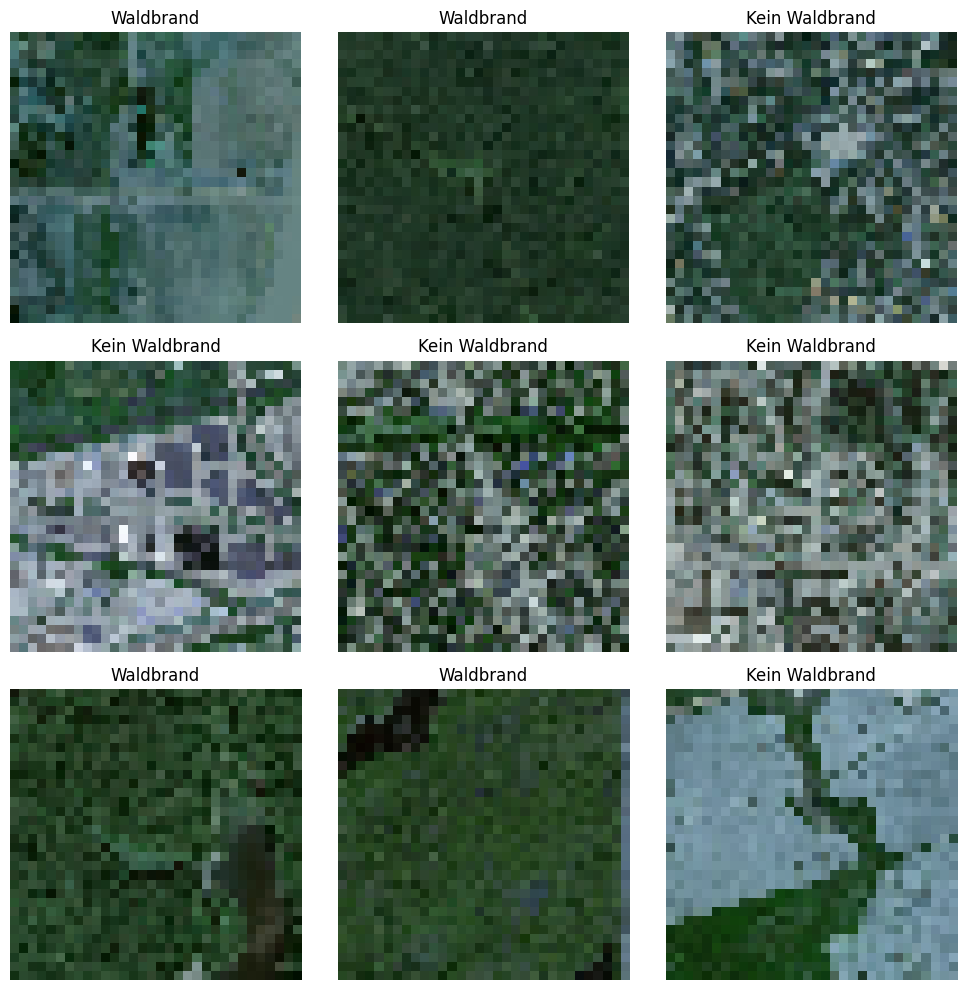

In [106]:
print(f"Training: {len(X_train)} Bilder")
print(f"Validierung: {len(X_val)} Bilder")
print(f"Test: {len(X_test)} Bilder")

def zeige_batch(bilder, labels, anzahl=9):
    plt.figure(figsize=(10, 10))
    for i in range(min(anzahl, len(bilder))):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(bilder[i])
        if isinstance(labels[i], np.ndarray) and len(labels[i]) > 1:
            label = np.argmax(labels[i])
        else:
            label = labels[i]

        plt.title('Waldbrand' if label == 1 else 'Kein Waldbrand')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

zeige_batch(X_train, y_train_cat)
image_batch, label_batch = next(train_generator)

CNN erstellen

In [109]:
img_height, img_width = 32, 32
def create_custom_cnn():
    model = models.Sequential([
        # Expliziter Input-Layer
        layers.Input(shape=(img_height, img_width, 3)),

        # Convolutional-Schichten (ohne input_shape Parameter)
        layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
        layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.BatchNormalization(),

        # Flatten
        layers.Flatten(),

        # Dense-Schichten
        layers.Dropout(0.2),
        layers.Dense(64, activation='relu'),
        layers.Dense(2, activation='softmax')
    ])

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

custom_model = create_custom_cnn()
custom_model.summary()

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_36 (Conv2D)              │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_37 (Conv2D)              │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_28 (MaxPooling2D) │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_13 (Flatten)            │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 64)             │     1,048,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,068,418 (4.08 MB)

 Trainable params: 1,068,290 (4.08 MB)

 Non-trainable params: 128 (512.00 B)

Modelltraining

In [110]:
epochs = 15
steps_per_epoch = len(X_train) // batch_size

# early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=0.00001
)

custom_history = custom_model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=(X_val, y_val_cat),
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/15
945/945 ━━━━━━━━━━━━━━━━━━━━ 43s 44ms/step - accuracy: 0.8962 - loss: 0.3125 - val_accuracy: 0.7951 - val_loss: 0.5529 - learning_rate: 0.0010
Epoch 2/15
945/945 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8438 - loss: 0.4117 - val_accuracy: 0.8065 - val_loss: 0.5187 - learning_rate: 0.0010
Epoch 3/15
945/945 ━━━━━━━━━━━━━━━━━━━━ 45s 48ms/step - accuracy: 0.9268 - loss: 0.1932 - val_accuracy: 0.7971 - val_loss: 1.3804 - learning_rate: 0.0010
Epoch 4/15
945/945 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9688 - loss: 0.1076 - val_accuracy: 0.7938 - val_loss: 1.4197 - learning_rate: 0.0010
Epoch 5/15
945/945 ━━━━━━━━━━━━━━━━━━━━ 38s 41ms/step - accuracy: 0.9289 - loss: 0.1823 - val_accuracy: 0.8268 - val_loss: 0.8302 - learning_rate: 0.0010
Epoch 6/15
945/945 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8750 - loss: 0.3928 - val_accuracy: 0.8249 - val_loss: 0.8391 - learning_rate: 2.0000e-04
Epoch 7/15
945/945 ━━━━━━━━━━━━━━━━━━━━ 42s 45ms/step - accuracy: 0.9438 - los

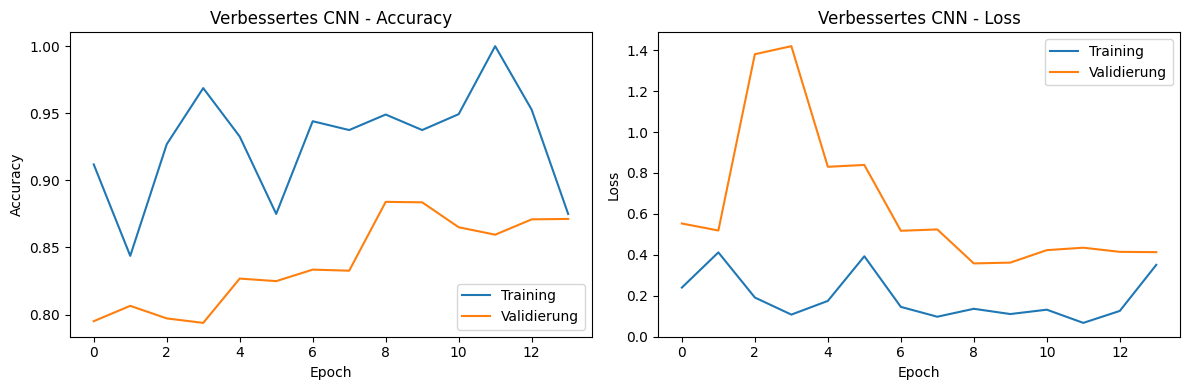

197/197 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.9376 - loss: 0.1840
Test-Accuracy: 0.8863
197/197 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step


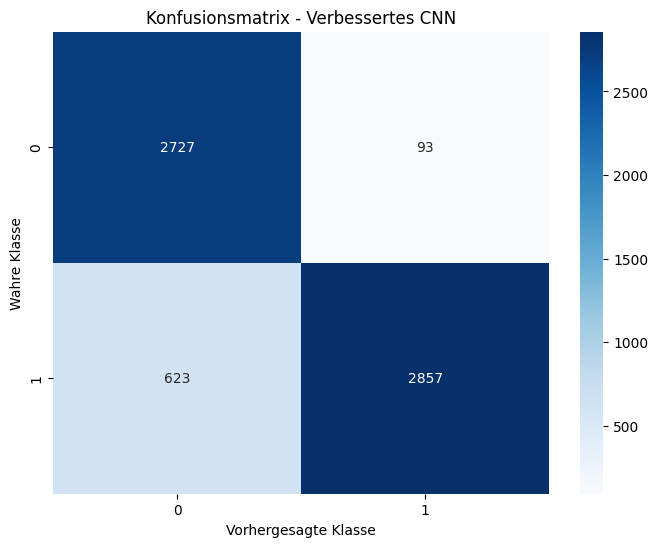


Klassifikationsbericht:
                precision    recall  f1-score   support

Kein Waldbrand       0.81      0.97      0.88      2820
     Waldbrand       0.97      0.82      0.89      3480

      accuracy                           0.89      6300
     macro avg       0.89      0.89      0.89      6300
  weighted avg       0.90      0.89      0.89      6300



In [111]:
def plot_history(history, title):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f'{title} - Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Training', 'Validierung'], loc='lower right')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'{title} - Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Training', 'Validierung'], loc='upper right')

    plt.tight_layout()
    plt.show()


plot_history(custom_history, 'Verbessertes CNN')

test_loss, test_acc = custom_model.evaluate(X_test, y_test_cat)
print(f"Test-Accuracy: {test_acc:.4f}")

predictions = custom_model.predict(X_test)
y_pred = np.argmax(predictions, axis=1)
y_true = np.argmax(y_test_cat, axis=1)

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f'Konfusionsmatrix - Verbessertes CNN')
plt.ylabel('Wahre Klasse')
plt.xlabel('Vorhergesagte Klasse')
plt.show()

print("\nKlassifikationsbericht:")
print(classification_report(y_true, y_pred, target_names=['Kein Waldbrand', 'Waldbrand']))


def vorhersage_einzelbild(bild_pfad):
    bild = cv2.imread(bild_pfad)
    bild = cv2.resize(bild, (img_width, img_height))
    bild = bild / 255.0
    bild = np.expand_dims(bild, axis=0)

    vorhersage = custom_model.predict(bild)
    klasse_idx = np.argmax(vorhersage[0])
    klasse_wahrscheinlichkeit = vorhersage[0][klasse_idx]

    klasse_name = 'Waldbrand' if klasse_idx == 1 else 'Kein Waldbrand'

    plt.figure(figsize=(6, 6))
    plt.imshow(cv2.cvtColor(cv2.imread(bild_pfad), cv2.COLOR_BGR2RGB))
    plt.title(f'Vorhersage: {klasse_name} ({klasse_wahrscheinlichkeit:.2%})')
    plt.axis('off')
    plt.show()

    return klasse_name, klasse_wahrscheinlichkeit


Waldbrand test

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


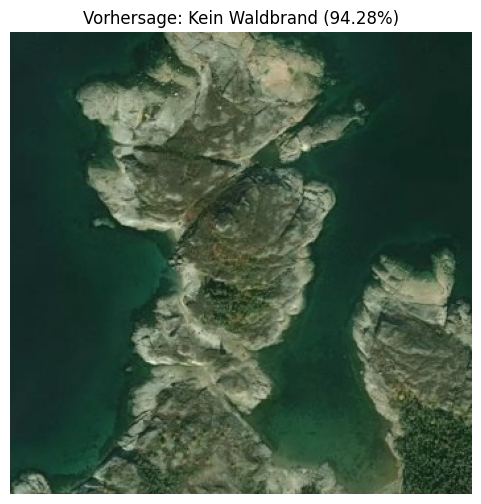

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


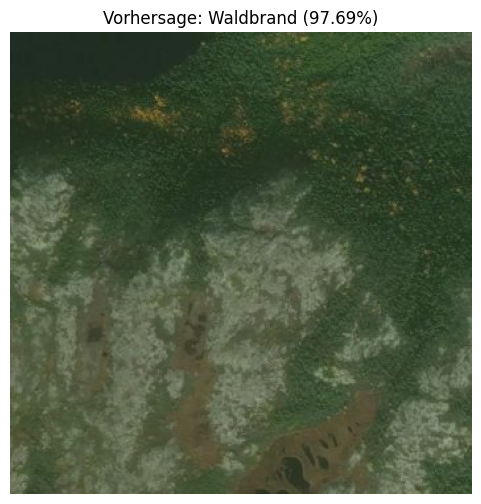

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


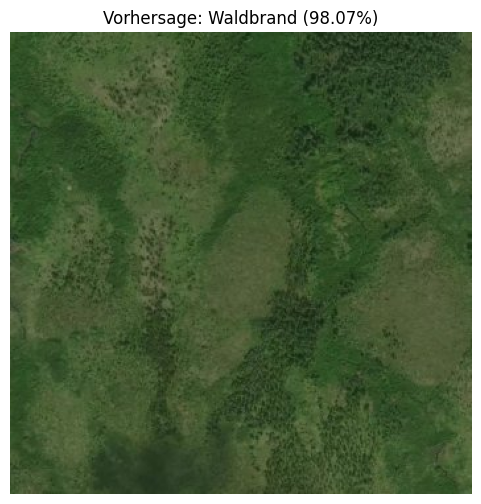

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


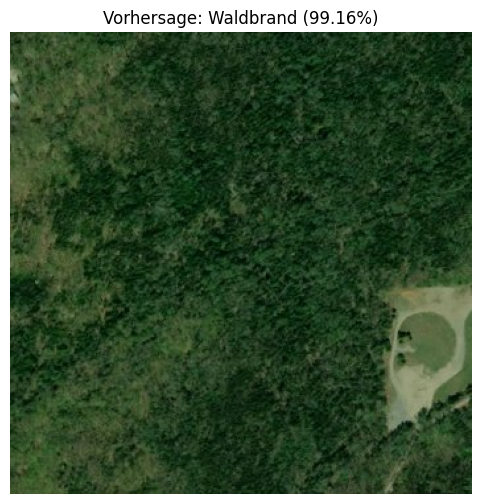

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


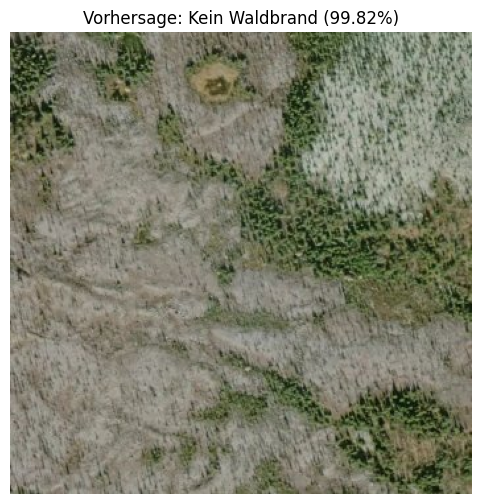

('Kein Waldbrand', np.float32(0.9981806))

In [119]:
test_bild_pfad = "dataset/valid/wildfire/-67.01362,49.83423.jpg"
vorhersage_einzelbild(test_bild_pfad)
test_bild_pfad = "dataset/train/wildfire/-60.9444,50.3885.jpg"
vorhersage_einzelbild(test_bild_pfad)
test_bild_pfad = "dataset/test/wildfire/-78.94987,51.10492.jpg"
vorhersage_einzelbild(test_bild_pfad)
test_bild_pfad = "dataset/train/wildfire/-71.30437,46.91247.jpg"
vorhersage_einzelbild(test_bild_pfad)
test_bild_pfad = "dataset/valid/wildfire/-59.0017,51.9556.jpg"
vorhersage_einzelbild(test_bild_pfad)

Kein Waldbrand test

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


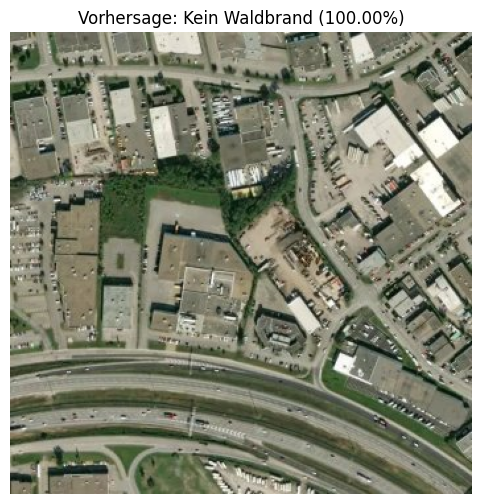

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


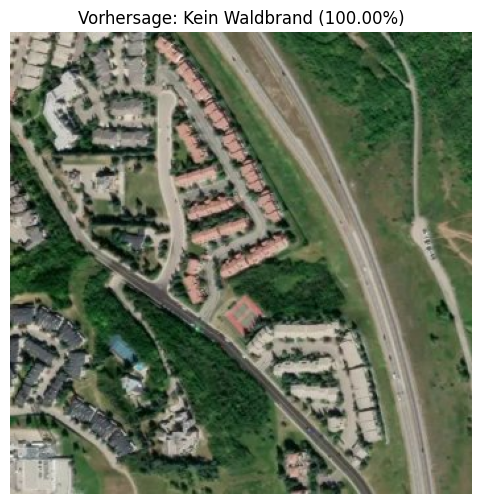

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


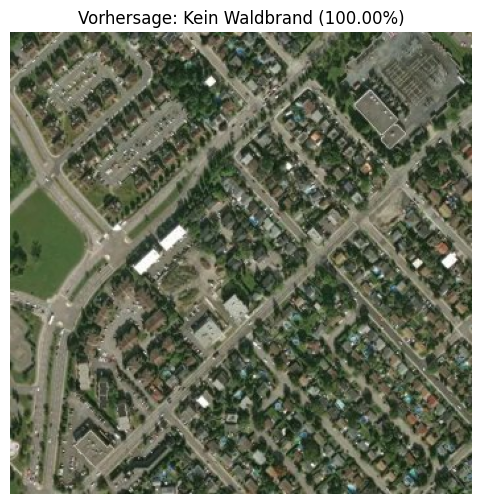

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


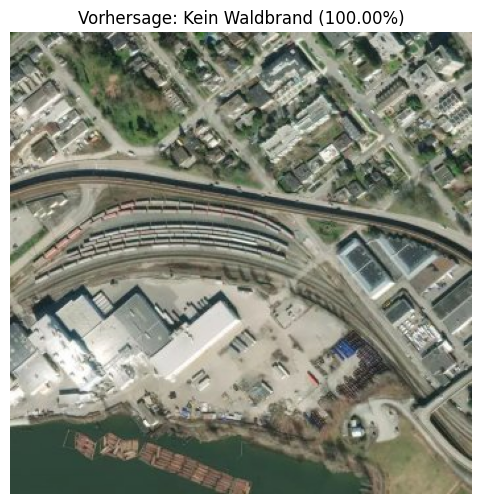

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


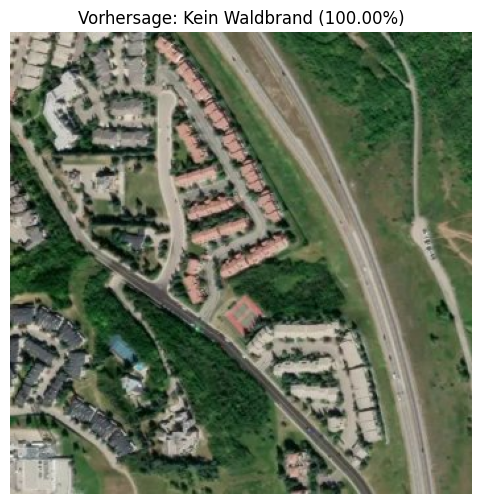

('Kein Waldbrand', np.float32(0.9999999))

In [118]:
test_bild_pfad = "dataset/valid/nowildfire/-73.7592,45.582753.jpg"
vorhersage_einzelbild(test_bild_pfad)
test_bild_pfad = "dataset/valid/nowildfire/-114.167338,51.061201.jpg"
vorhersage_einzelbild(test_bild_pfad)
test_bild_pfad = "dataset/train/nowildfire/-73.4525,45.545352.jpg"
vorhersage_einzelbild(test_bild_pfad)
test_bild_pfad = "dataset/test/nowildfire/-122.93133,49.202953.jpg"
vorhersage_einzelbild(test_bild_pfad)
test_bild_pfad = "dataset/valid/nowildfire/-114.167338,51.061201.jpg"
vorhersage_einzelbild(test_bild_pfad)